In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py

task_to_scores = {}
task_to_hyp_scores = {}

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    task_to_scores[task] = np.array(f['contrib_scores'][task])
    task_to_hyp_scores[task] = np.array(f['hyp_contrib_scores'][task])

onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences])

Double check by plotting

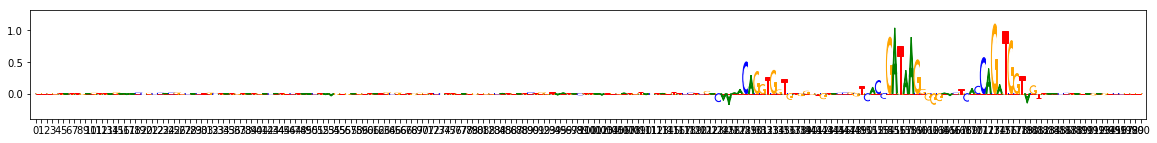

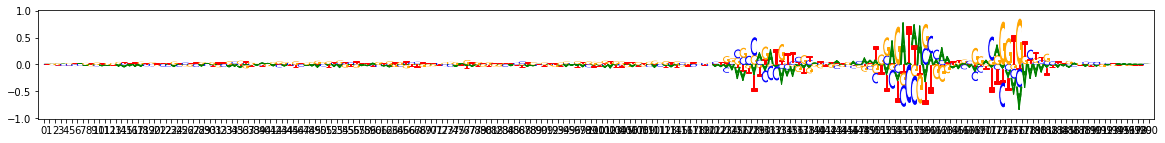

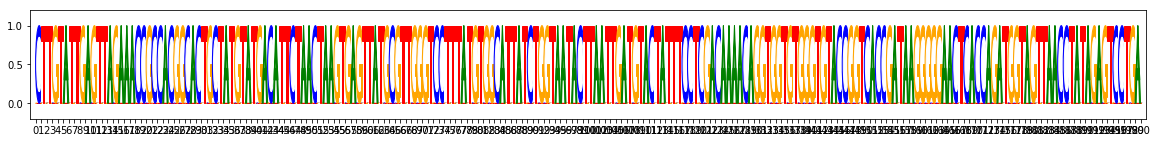

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Done 0


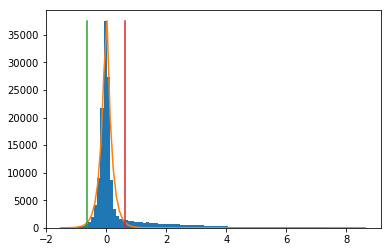

Computed threshold 0.6416451864009939
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7573 coords
1851 coords remaining after thresholding
On task task1
Done 0


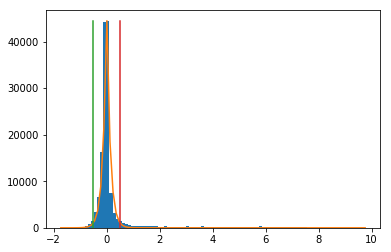

Computed threshold 0.5160285779594265
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1530 coords remaining after thresholding
On task task2
Done 0


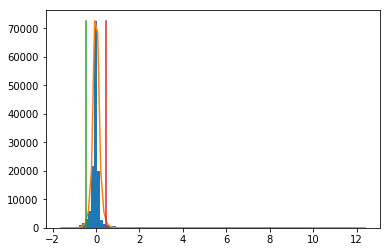

Computed threshold 0.445660070894207
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1653 coords remaining after thresholding
After resolving overlaps, got 2660 seqlets
4 activity patterns with support >= 200 out of 27 possible patterns
Metacluster sizes:  [1071, 763, 264, 261]
Idx to activities:  {0: '1,1,0', 1: '1,0,1', 2: '0,-1,0', 3: '0,0,-1'}
On metacluster 3
Metacluster size 261
Relevant tasks:  ('task2',)
Relevant signs:  (-1,)
(Round 1) num seqlets: 261
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.28 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.2609269619 seconds
Wrote graph to binary file in 0.0237970352173 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775125
Louvain completed 51 runs in 0.703799962997 seconds
Preproc + Louvain took 2.04050302505 s
Got 12 clusters after round 1
Counts:
{0: 32, 1: 27, 2: 22, 3: 19, 4: 17, 5: 17, 6: 17, 7: 15, 8: 12, 9: 10, 10: 9, 11: 8}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 32 seqlets
Trimmed 9 out of 32
Skipped 2 seqlets
Dropping cluster 0 with 21 seqlets due to sign disagreement
Aggregating for cluster 1 with 27 seqlets
Trimmed 0 out of 27
Skipped 3 seqlets
Aggregating for cluster 2 with 22 seqlets
Trimmed 0 out of 22
Skipped 1 seqlets
Aggregating for cluster 3 with 19 seqlets
Trimmed 0 out of 19
Skipped 2 seqlets
Aggregating for cluster 4 with 17 seqlets
Trimmed 0 out of 17
Skipped 9 seqlets
Aggregating for cluster 5 with 17 seqlets
Trimmed 0 out of 17
Skipped 3 seqlets
Aggreg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.1257109642 seconds
Wrote graph to binary file in 0.0101900100708 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801165
Louvain completed 51 runs in 0.690052032471 seconds
Preproc + Louvain took 1.8696641922 s
Got 9 clusters after round 2
Counts:
{0: 23, 1: 19, 2: 18, 3: 14, 4: 14, 5: 13, 6: 11, 7: 10, 8: 9}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 1 with 19 seqlets
Trimmed 6 out of 19
Aggregating for cluster 2 with 18 seqlets
Trimmed 1 out of 18
Aggregating for cluster 3 with 14 seqlets
Trimmed 1 out of 14
Aggregating for cluster 4 with 14 seqlets
Trimmed 1 out of 14
Aggregating for cluster 5 with 13 seqlets
Trimmed 0 out of 13
Aggregating for cluster 6 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 7 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 8 with 9 seqlets
Trimmed 0 out of 9
Got 9 clusters

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.35841488838 seconds
Wrote graph to binary file in 0.0242519378662 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.83015
After 2 runs, maximum modularity is Q = 0.836996
After 3 runs, maximum modularity is Q = 0.846692
Louvain completed 53 runs in 0.738021850586 seconds
Preproc + Louvain took 2.18334794044 s
Got 9 clusters after round 1
Counts:
{0: 31, 1: 28, 2: 28, 3: 22, 4: 21, 5: 20, 6: 18, 7: 17, 8: 17}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 31 seqlets
Trimmed 3 out of 31
Skipped 3 seqlets
Aggregating for cluster 1 with 28 seqlets
Trimmed 1 out of 28
Skipped 2 seqlets
Dropping cluster 1 with 25 seqlets due to sign disagreement
Aggregating for cluster 2 with 28 seqlets
Trimmed 0 out of 28
Skipped 7 seqlets
Aggregating for cluster 3 with 22 seqlets
Trimmed 0 out of 22
Skipped 2 seqlets
Aggregating for cluster 4 with 21 seqlets
Trimmed 0 out of 21
Skipped 2 seqlets
Aggregatin

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.258466959 seconds
Wrote graph to binary file in 0.00998020172119 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.835475
After 4 runs, maximum modularity is Q = 0.840226
Louvain completed 54 runs in 0.728072881699 seconds
Preproc + Louvain took 2.04861092567 s
Got 11 clusters after round 2
Counts:
{0: 22, 1: 18, 2: 17, 3: 14, 4: 14, 5: 13, 6: 12, 7: 12, 8: 10, 9: 7, 10: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 22 seqlets
Trimmed 0 out of 22
Skipped 1 seqlets
Aggregating for cluster 1 with 18 seqlets
Trimmed 0 out of 18
Skipped 1 seqlets
Aggregating for cluster 2 with 17 seqlets
Trimmed 1 out of 17
Aggregating for cluster 3 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 4 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 5 with 13 seqlets
Trimmed 0 out of 13
Aggregating for cluster 6 with 12 seqlets
Trimmed 0 out of 12
Dropping cluster 6 with 12 seqlets 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 2.05547094345 seconds
Wrote graph to binary file in 0.201573848724 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.684811
After 2 runs, maximum modularity is Q = 0.694922
After 36 runs, maximum modularity is Q = 0.695547
Louvain completed 86 runs in 1.81357002258 seconds
Preproc + Louvain took 4.18596601486 s
Got 7 clusters after round 1
Counts:
{0: 145, 1: 121, 2: 106, 3: 94, 4: 88, 5: 65, 6: 32}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 145 seqlets
Trimmed 10 out of 145
Skipped 19 seqlets
Aggregating for cluster 1 with 121 seqlets
Trimmed 11 out of 121
Skipped 12 seqlets
Aggregating for cluster 2 with 106 seqlets
Trimmed 11 out of 106
Skipped 11 seqlets
Aggregating for cluster 3 with 94 seqlets
Trimmed 0 out of 94
Skipped 12 seqlets
Aggregating for cluster 4 with 88 seqlets
Trimmed 2 out of 88
Skipped 9 seqlets
Aggregating for cluster 5 with 65 seqlets
Trimmed 6 out of 65
Skippe

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.3s finished


Louvain completed 200 runs in 1.95041894913 seconds
Wrote graph to binary file in 0.117479801178 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.71384
Louvain completed 51 runs in 0.889862060547 seconds
Preproc + Louvain took 3.05658102036 s
Got 8 clusters after round 2
Counts:
{0: 110, 1: 109, 2: 91, 3: 71, 4: 46, 5: 36, 6: 29, 7: 28}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 110 seqlets
Trimmed 2 out of 110
Skipped 1 seqlets
Aggregating for cluster 1 with 109 seqlets
Trimmed 0 out of 109
Aggregating for cluster 2 with 91 seqlets
Trimmed 1 out of 91
Aggregating for cluster 3 with 71 seqlets
Trimmed 0 out of 71
Aggregating for cluster 4 with 46 seqlets
Trimmed 1 out of 46
Aggregating for cluster 5 with 36 seqlets
Trimmed 1 out of 36
Aggregating for cluster 6 with 29 seqlets
Trimmed 0 out of 29
Aggregating for cluster 7 with 28 seqlets
Trimmed 1 out of 28
Got 8 clusters
Splitting into subclusters...
Inspecting 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.33690404892 seconds
Wrote graph to binary file in 0.230312824249 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.684941
After 4 runs, maximum modularity is Q = 0.685046
After 6 runs, maximum modularity is Q = 0.685627
After 18 runs, maximum modularity is Q = 0.692749
After 47 runs, maximum modularity is Q = 0.694471
Louvain completed 97 runs in 2.23755407333 seconds
Preproc + Louvain took 4.92547798157 s
Got 6 clusters after round 1
Counts:
{0: 158, 1: 151, 2: 146, 3: 135, 4: 112, 5: 46}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 158 seqlets
Trimmed 9 out of 158
Skipped 17 seqlets
Aggregating for cluster 1 with 151 seqlets
Trimmed 7 out of 151
Skipped 9 seqlets
Aggregating for cluster 2 with 146 seqlets
Trimmed 10 out of 146
Skipped 17 seqlets
Aggregating for cluster 3 with 135 seqlets
Trimmed 3 out of 135
Skipped 11 seqlets
Aggregating for cluster 4 with 112 seqlets
Trimmed 1 ou

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.3s finished


Louvain completed 200 runs in 2.08957290649 seconds
Wrote graph to binary file in 0.212274074554 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.643258
After 4 runs, maximum modularity is Q = 0.654559
Louvain completed 54 runs in 1.24200296402 seconds
Preproc + Louvain took 3.67656493187 s
Got 8 clusters after round 2
Counts:
{0: 133, 1: 130, 2: 110, 3: 89, 4: 64, 5: 45, 6: 44, 7: 18}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 133 seqlets
Trimmed 14 out of 133
Aggregating for cluster 1 with 130 seqlets
Trimmed 1 out of 130
Aggregating for cluster 2 with 110 seqlets
Trimmed 5 out of 110
Aggregating for cluster 3 with 89 seqlets
Trimmed 0 out of 89
Aggregating for cluster 4 with 64 seqlets
Trimmed 3 out of 64
Aggregating for cluster 5 with 45 seqlets
Trimmed 5 out of 45
Aggregating for cluster 6 with 44 seqlets
Trimmed 0 out of 44
Aggregating for cluster 7 with 18 seqlets
Trimmed 0 out of 18
Got 8 clusters
Splitt

In [39]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [40]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1 1 0]
pattern_0
total seqlets: 442
Task 0 hypothetical scores:


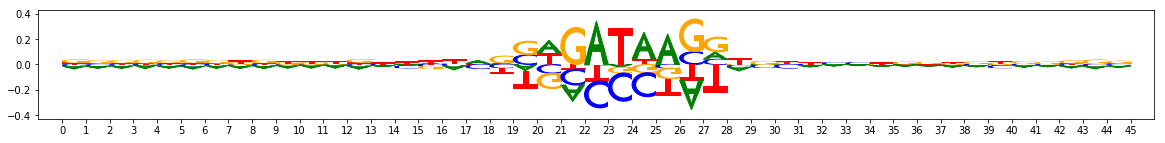

Task 0 actual importance scores:


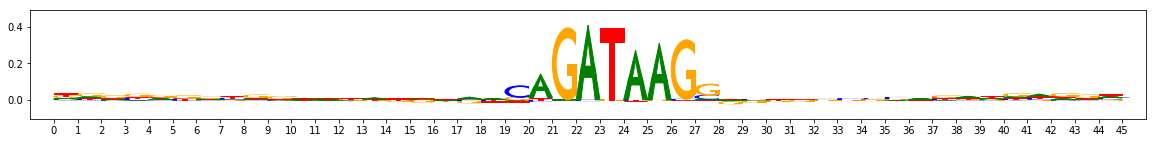

Task 1 hypothetical scores:


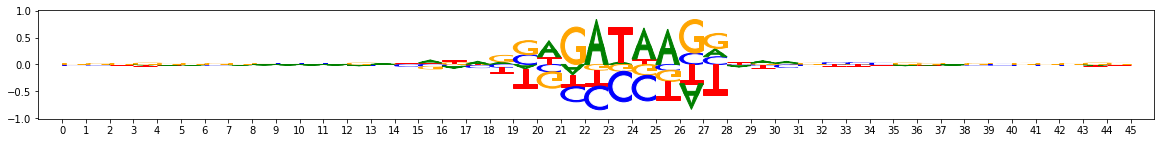

Task 1 actual importance scores:


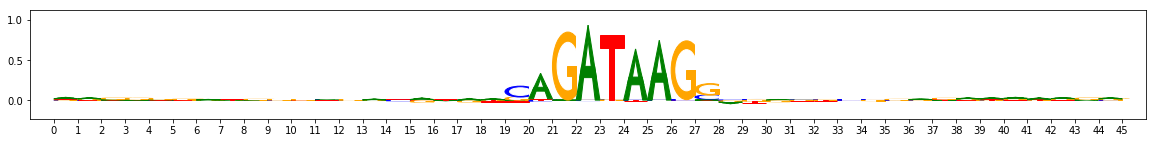

Task 2 hypothetical scores:


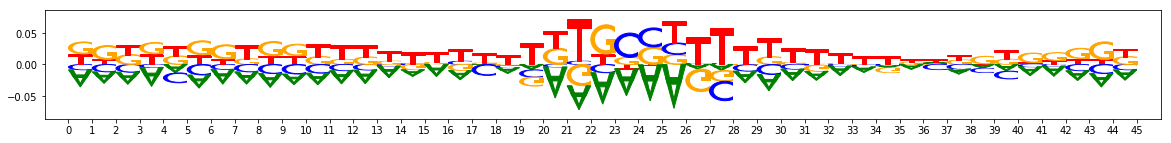

Task 2 actual importance scores:


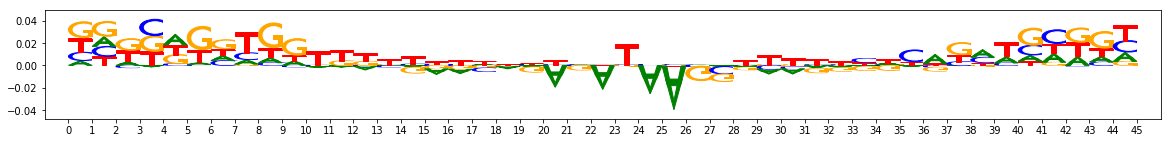

onehot, fwd and rev:


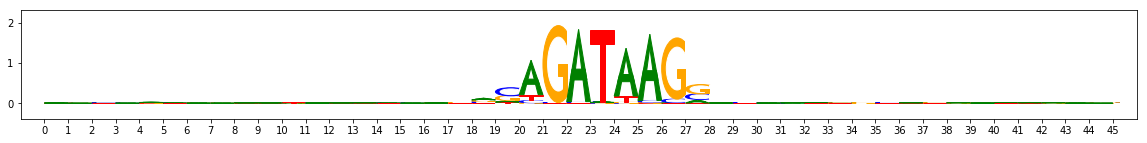

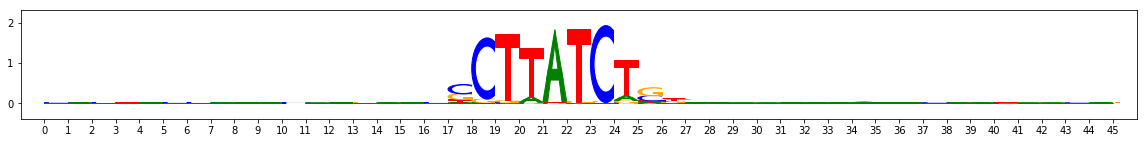

pattern_1
total seqlets: 127
Task 0 hypothetical scores:


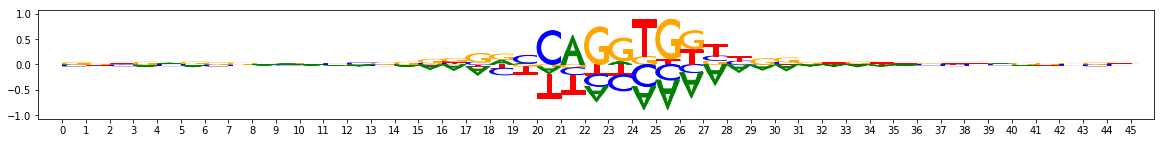

Task 0 actual importance scores:


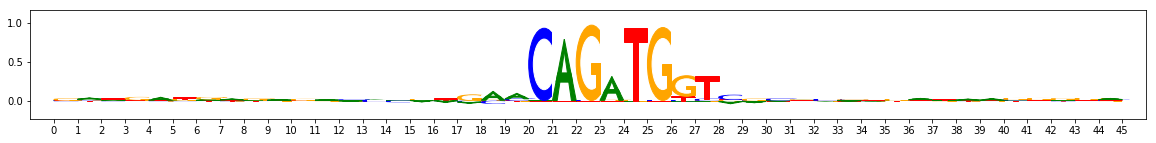

Task 1 hypothetical scores:


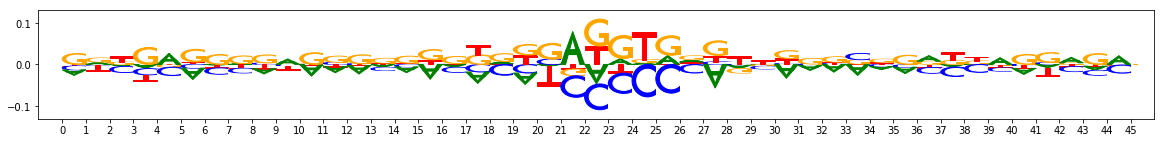

Task 1 actual importance scores:


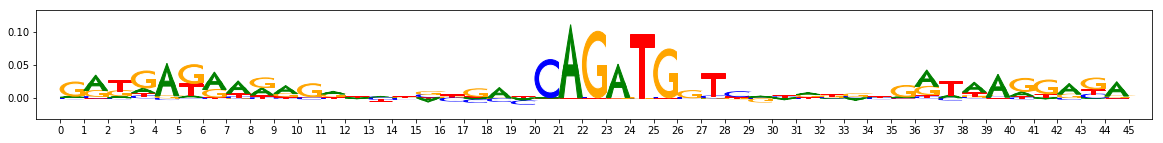

Task 2 hypothetical scores:


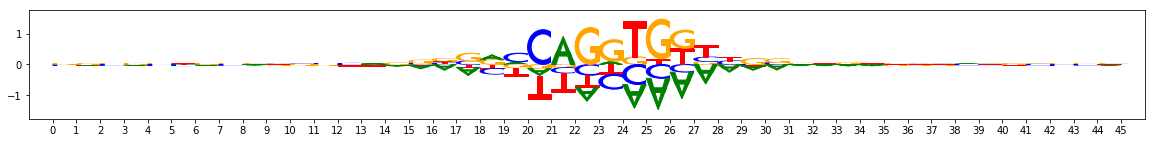

Task 2 actual importance scores:


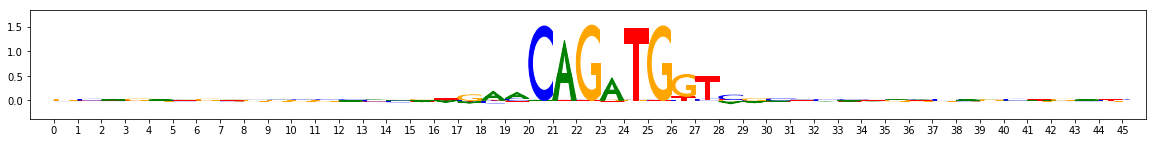

onehot, fwd and rev:


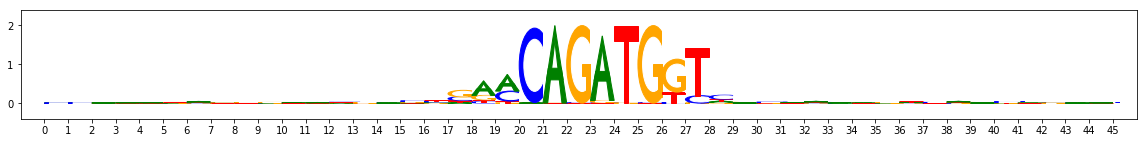

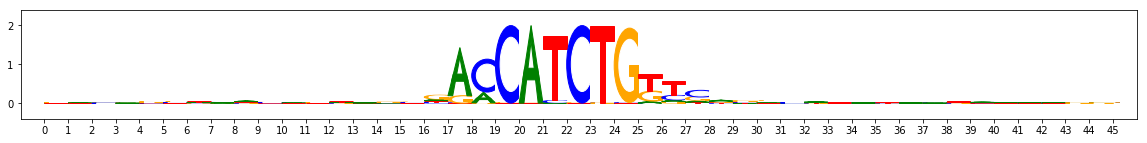

metacluster1
activity pattern: [1 0 1]
pattern_0
total seqlets: 503
Task 0 hypothetical scores:


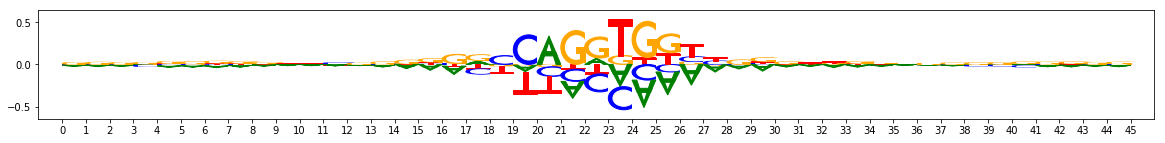

Task 0 actual importance scores:


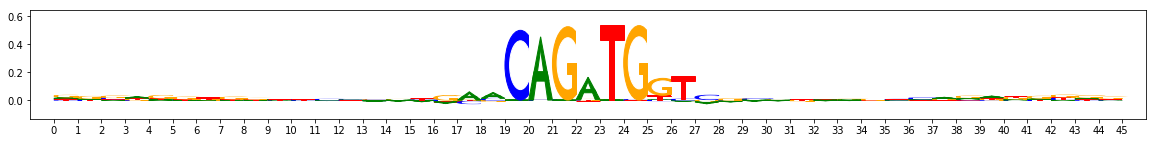

Task 1 hypothetical scores:


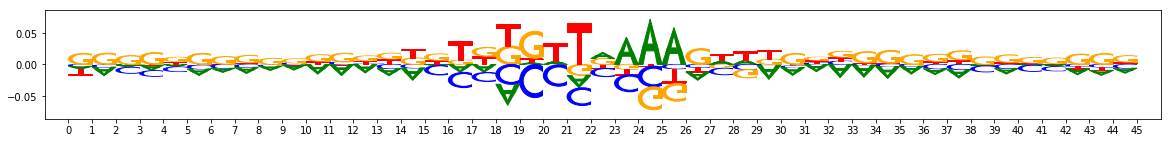

Task 1 actual importance scores:


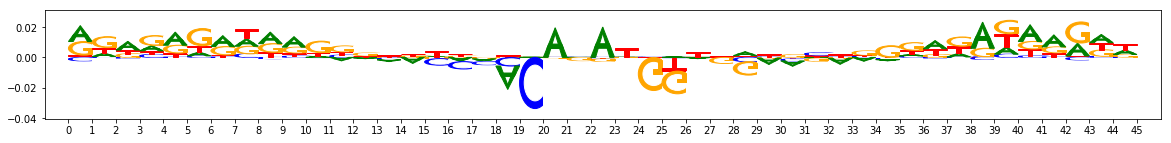

Task 2 hypothetical scores:


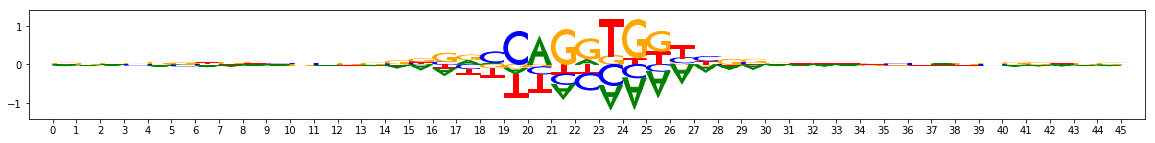

Task 2 actual importance scores:


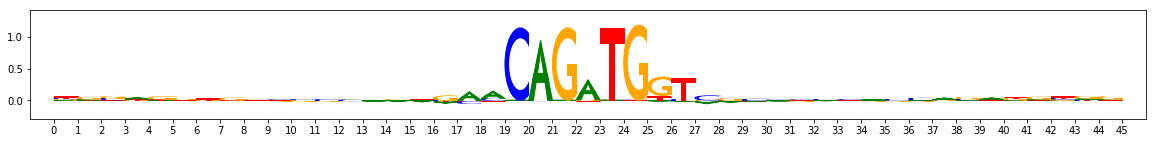

onehot, fwd and rev:


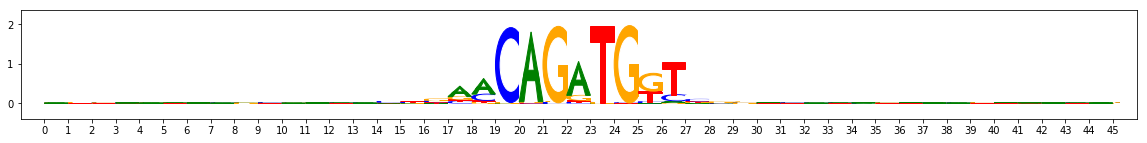

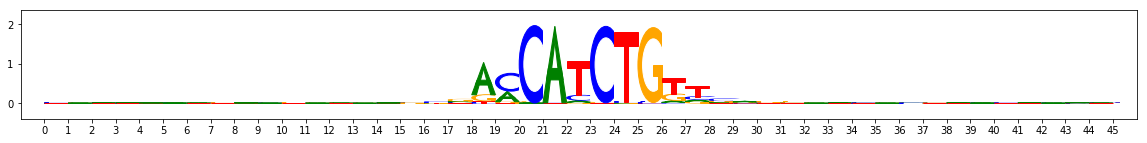

metacluster2
activity pattern: [ 0 -1  0]
metacluster3
activity pattern: [ 0  0 -1]


In [41]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()